Train and score a boosted decision tree model using [LightGBM Python package](https://github.com/Microsoft/LightGBM) from Microsoft, which is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms.  

In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
import lightgbm as lgb

In [2]:
## Append TSPerf path to sys.path
nb_dir = os.path.split(os.getcwd())[0]
tsperf_dir = os.path.dirname(os.path.dirname(os.path.dirname(nb_dir)))
if tsperf_dir not in sys.path:
    sys.path.append(tsperf_dir)

In [3]:
from common.metrics import MAPE
import retail_sales.OrangeJuice_Pt_3Weeks_Weekly.common.benchmark_settings as bs

In [4]:
# ## Define parameters
# NUM_ROUNDS = 12
# TRAIN_START_WEEK = 40
# TRAIN_END_WEEK_LIST = range(135, 159, 2)
# TEST_START_WEEK_LIST = range(137, 161, 2)
# TEST_END_WEEK_LIST = range(138, 162, 2)
DATA_DIR = '../../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

In [5]:
## Utility functions
def df_from_cartesian_product(dict_in):
    """Generate a Pandas dataframe from Cartesian product of lists
    
    Args: 
        dict_in: Dictionary containing multiple lists
        
    Returns:
        df: Pandas dataframe corresponding to the Caresian product of the lists
    """
    from collections import OrderedDict
    from itertools import product
    od = OrderedDict(sorted(dict_in.items()))
    cart = list(product(*od.values()))
    df = pd.DataFrame(cart, columns=od.keys())
    return df

def lagged_features(df, lags):
    """Create lagged features based on time series data
    
    Args:
        df (dataframe): Input time series data sorted by time
        lags (list): Lag lengths
        
    Returns:
        fea (dataframe): Lagged features 
    """
    df_list = []
    for lag in lags:
        df_shifted = df.shift(lag)
        df_shifted.columns = [x + '_lag' + str(lag) for x in df_shifted.columns]
        df_list.append(df_shifted)
    fea = pd.concat(df_list, axis=1)
    return fea

def create_features(df):
    lagged_fea = lagged_features(df.drop(['brand','store','week'], axis=1), lags)
    return pd.concat([df[['brand' , 'store', 'week', 'logmove']], lagged_fea], axis=1)

def make_predictions(df, model):
    predictions = pd.DataFrame({'logmove': model.predict(df, num_iteration=bst.best_iteration or MAX_ROUNDS)})
    return pd.concat([df[['brand', 'store', 'week']].reset_index(drop=True), predictions], axis=1)

def evaluate(pred, actual):
    pred['pred_units'] = pred['logmove'].apply(lambda x: round(math.exp(x)))
    actual['actual_units'] = actual['logmove'].apply(lambda x: round(math.exp(x)))
    return MAPE(pred['pred_units'], actual['actual_units'])*100

In [6]:
## Model parameters
params = {
    'num_leaves': 80,
    'objective': 'regression',
    'min_data_in_leaf': 100, #200,
    'learning_rate': 0.1, #0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 16
}
MAX_ROUNDS = 5000 #5000

In [7]:
import itertools
lags = [2] #[2,3,4]
lags_str = [str(x) for x in lags]
categ_fea = ["".join(res) for res in itertools.product(['deal_lag', 'feat_lag'], lags_str)]
categ_fea = ['store', 'brand'] + categ_fea

In [8]:
pred_all = []
metric_all = []
for r in range(bs.NUM_ROUNDS): #range(bs.NUM_ROUNDS):
    print('---- Round ' + str(r+1) + ' ----')
    train_df = pd.read_csv(os.path.join(TRAIN_DIR, 'train_round_'+str(r+1)+'.csv'))
    print(train_df.head(3))
    print('')
    # Fill missing values
    store_list = train_df['store'].unique()
    brand_list = train_df['brand'].unique()
    #week_list = range(bs.TRAIN_START_WEEK, bs.TRAIN_END_WEEK_LIST[r]+1)
    week_list = range(bs.TRAIN_START_WEEK, bs.TEST_END_WEEK_LIST[r]+1)
    d = {'store': store_list,
         'brand': brand_list,
         'week': week_list}        
    data_grid = df_from_cartesian_product(d)
    data_filled = pd.merge(data_grid, train_df, how='left', 
                            on=['store', 'brand', 'week'])
    print('Number of missing rows is {}'.format(data_filled[data_filled.isnull().any(axis=1)].shape[0]))
    print('')
    data_filled = data_filled.groupby(['store', 'brand']). \
                                apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
    
    # Create lagged features
    features = data_filled.groupby(['store','brand']). \
                            apply(lambda x: create_features(x))
    train_fea = features[features.week <= bs.TRAIN_END_WEEK_LIST[r]].reset_index(drop=True)
    print(train_fea.head(1))
    print('')
    print('Training and predicting models...')
    evals_result = {} # to record eval results for plotting
    dtrain = lgb.Dataset(
                train_fea.drop('logmove', axis=1, inplace=False), 
                label = train_fea['logmove']
    )
    bst = lgb.train(
        params, 
        dtrain, 
        num_boost_round = MAX_ROUNDS,
        valid_sets = [dtrain], 
        categorical_feature = categ_fea,
        early_stopping_rounds = 125, 
        evals_result = evals_result,
        verbose_eval = 100
    )
    # Generate forecasts
    test_fea = features[features.week >= bs.TEST_START_WEEK_LIST[r]].reset_index(drop=True)
    pred = test_fea.groupby(['store','brand']). \
                    apply(lambda x: make_predictions(x, bst)). \
                    reset_index(drop=True)
    print(pred)
    print('')
    # Evaluate prediction accuracy
    test_df = pd.read_csv(os.path.join(TEST_DIR, 'test_round_'+str(r+1)+'.csv'))
    metric_value = evaluate(pred, test_df)
    print('')
    print('MAPE of current round is {}'.format(metric_value))
    print('')
    # Keep the predictions and accuracy
    pred_all.append(pred)
    metric_all.append(metric_value)

---- Round 1 ----
   store  brand  week   logmove  constant    price1    price2    price3  \
0      2      1    40  9.018695         1  0.060469  0.060497  0.042031   
1      2      1    46  8.723231         1  0.060469  0.060312  0.045156   
2      2      1    47  8.253228         1  0.060469  0.060312  0.045156   

     price4    price5    price6    price7    price8    price9   price10  \
0  0.029531  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844   
1  0.046719  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031   
2  0.046719  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656   

    price11  deal  feat     profit  
0  0.038984     1   0.0  37.992326  
1  0.038984     0   0.0  30.126667  
2  0.038984     0   0.0  30.000000  

Number of missing rows is 6204

   brand  store  week   logmove  logmove_lag2  constant_lag2  price1_lag2  \
0      1      2    40  9.018695           NaN            NaN          NaN   

   price2_lag2  price3_lag2  price4_lag2  pr

/anaconda/envs/py35/lib/python3.5/site-packages/lightgbm/basic.py:988: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['brand', 'deal_lag2', 'feat_lag2', 'store']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[100]	training's l2: 0.266488
[200]	training's l2: 0.19229
[300]	training's l2: 0.158313
[400]	training's l2: 0.137848
[500]	training's l2: 0.122654
[600]	training's l2: 0.112029
[700]	training's l2: 0.102161
[800]	training's l2: 0.0944019
[900]	training's l2: 0.0876973
[1000]	training's l2: 0.0821083
[1100]	training's l2: 0.0771434
[1200]	training's l2: 0.0728598
[1300]	training's l2: 0.0690778
[1400]	training's l2: 0.0656885
[1500]	training's l2: 0.0626349
[1600]	training's l2: 0.0598821
[1700]	training's l2: 0.0572827
[1800]	training's l2: 0.0549692
[1900]	training's l2: 0.0528099
[2000]	training's l2: 0.0508134
[2100]	training's l2: 0.0489353
[2200]	training's l2: 0.0471932
[2300]	training's l2: 0.0456095
[2400]	training's l2: 0.0440873
[2500]	training's l2: 0.0426476
[2600]	training's l2: 0.0413572
[2700]	training's l2: 0.0401451
[2800]	training's l2: 0.0389514
[2900]	training's l2: 0.0378191
[3000]	training's l2: 0.0367658
[3100]	training's l2: 0.0357497
[3200]	training's l2: 0.0

/anaconda/envs/py35/lib/python3.5/site-packages/lightgbm/basic.py:988: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['brand', 'deal_lag2', 'feat_lag2', 'store']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[100]	training's l2: 0.266806
[200]	training's l2: 0.192031
[300]	training's l2: 0.157181
[400]	training's l2: 0.13667
[500]	training's l2: 0.121956
[600]	training's l2: 0.111358
[700]	training's l2: 0.101954
[800]	training's l2: 0.0940483
[900]	training's l2: 0.0874615
[1000]	training's l2: 0.0820078
[1100]	training's l2: 0.0770957
[1200]	training's l2: 0.0728044
[1300]	training's l2: 0.069053
[1400]	training's l2: 0.0656927
[1500]	training's l2: 0.0626422
[1600]	training's l2: 0.0599039
[1700]	training's l2: 0.0573587
[1800]	training's l2: 0.0550271
[1900]	training's l2: 0.0528682
[2000]	training's l2: 0.0508982
[2100]	training's l2: 0.0490132
[2200]	training's l2: 0.0472384
[2300]	training's l2: 0.0456362
[2400]	training's l2: 0.0440776
[2500]	training's l2: 0.042674
[2600]	training's l2: 0.0413326
[2700]	training's l2: 0.0400966
[2800]	training's l2: 0.0389417
[2900]	training's l2: 0.0378183
[3000]	training's l2: 0.0367726
[3100]	training's l2: 0.0358086
[3200]	training's l2: 0.034

   store  brand  week   logmove  constant    price1    price2    price3  \
0      2      1    40  9.018695         1  0.060469  0.060497  0.042031   
1      2      1    46  8.723231         1  0.060469  0.060312  0.045156   
2      2      1    47  8.253228         1  0.060469  0.060312  0.045156   

     price4    price5    price6    price7    price8    price9   price10  \
0  0.029531  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844   
1  0.046719  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031   
2  0.046719  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656   

    price11  deal  feat     profit  
0  0.038984     1   0.0  37.992326  
1  0.038984     0   0.0  30.126667  
2  0.038984     0   0.0  30.000000  

Number of missing rows is 6248

   brand  store  week   logmove  logmove_lag2  constant_lag2  price1_lag2  \
0      1      2    40  9.018695           NaN            NaN          NaN   

   price2_lag2  price3_lag2  price4_lag2  price5_lag2  price6_

      brand  store  week   logmove
0         1      2   145  9.305906
1         1      2   146  9.305906
2         2      2   145  8.662221
3         2      2   146  8.662221
4         3      2   145  7.494201
5         3      2   146  7.494201
6         4      2   145  9.422921
7         4      2   146  9.422921
8         5      2   145  8.269323
9         5      2   146  8.269323
10        6      2   145  7.552031
11        6      2   146  7.552031
12        7      2   145  7.020245
13        7      2   146  7.020245
14        8      2   145  7.233719
15        8      2   146  7.233719
16        9      2   145  6.633515
17        9      2   146  6.633515
18       10      2   145  8.083717
19       10      2   146  8.083717
20       11      2   145  8.669253
21       11      2   146  8.669253
22        1      5   145  9.037954
23        1      5   146  9.037954
24        2      5   145  8.742600
25        2      5   146  8.742600
26        3      5   145  8.229528
27        3      5  

   brand  store  week   logmove  logmove_lag2  constant_lag2  price1_lag2  \
0      1      2    40  9.018695           NaN            NaN          NaN   

   price2_lag2  price3_lag2  price4_lag2  price5_lag2  price6_lag2  \
0          NaN          NaN          NaN          NaN          NaN   

   price7_lag2  price8_lag2  price9_lag2  price10_lag2  price11_lag2  \
0          NaN          NaN          NaN           NaN           NaN   

   deal_lag2  feat_lag2  profit_lag2  
0        NaN        NaN          NaN  

Training and predicting models...
Training until validation scores don't improve for 125 rounds.
[100]	training's l2: 0.274998
[200]	training's l2: 0.201866
[300]	training's l2: 0.164721
[400]	training's l2: 0.143641
[500]	training's l2: 0.127554
[600]	training's l2: 0.116536
[700]	training's l2: 0.106387
[800]	training's l2: 0.0982117
[900]	training's l2: 0.0916526
[1000]	training's l2: 0.0860022
[1100]	training's l2: 0.0811725
[1200]	training's l2: 0.0765429
[1300]	training

   store  brand  week   logmove  constant    price1    price2    price3  \
0      2      1    40  9.018695         1  0.060469  0.060497  0.042031   
1      2      1    46  8.723231         1  0.060469  0.060312  0.045156   
2      2      1    47  8.253228         1  0.060469  0.060312  0.045156   

     price4    price5    price6    price7    price8    price9   price10  \
0  0.029531  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844   
1  0.046719  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031   
2  0.046719  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656   

    price11  deal  feat     profit  
0  0.038984     1   0.0  37.992326  
1  0.038984     0   0.0  30.126667  
2  0.038984     0   0.0  30.000000  

Number of missing rows is 6655

   brand  store  week   logmove  logmove_lag2  constant_lag2  price1_lag2  \
0      1      2    40  9.018695           NaN            NaN          NaN   

   price2_lag2  price3_lag2  price4_lag2  price5_lag2  price6_

      brand  store  week   logmove
0         1      2   155  8.970168
1         1      2   156  8.970168
2         2      2   155  8.251628
3         2      2   156  8.251628
4         3      2   155  8.068856
5         3      2   156  8.068856
6         4      2   155  7.999592
7         4      2   156  7.999592
8         5      2   155  8.889869
9         5      2   156  8.889869
10        6      2   155  7.637332
11        6      2   156  7.637332
12        7      2   155  7.378734
13        7      2   156  7.378734
14        8      2   155  7.530430
15        8      2   156  7.530430
16        9      2   155  7.243917
17        9      2   156  7.243917
18       10      2   155  9.237232
19       10      2   156  9.237232
20       11      2   155  7.819761
21       11      2   156  7.819761
22        1      5   155  8.420922
23        1      5   156  8.420922
24        2      5   155  8.842637
25        2      5   156  8.842637
26        3      5   155  8.161023
27        3      5  

   brand  store  week   logmove  logmove_lag2  constant_lag2  price1_lag2  \
0      1      2    40  9.018695           NaN            NaN          NaN   

   price2_lag2  price3_lag2  price4_lag2  price5_lag2  price6_lag2  \
0          NaN          NaN          NaN          NaN          NaN   

   price7_lag2  price8_lag2  price9_lag2  price10_lag2  price11_lag2  \
0          NaN          NaN          NaN           NaN           NaN   

   deal_lag2  feat_lag2  profit_lag2  
0        NaN        NaN          NaN  

Training and predicting models...
Training until validation scores don't improve for 125 rounds.
[100]	training's l2: 0.279949
[200]	training's l2: 0.209411
[300]	training's l2: 0.170882
[400]	training's l2: 0.148751
[500]	training's l2: 0.132091
[600]	training's l2: 0.121086
[700]	training's l2: 0.110973
[800]	training's l2: 0.102311
[900]	training's l2: 0.095037
[1000]	training's l2: 0.0892981
[1100]	training's l2: 0.0842091
[1200]	training's l2: 0.0794915
[1300]	training's

In [9]:
import matplotlib.pyplot as plt

print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='l2')
plt.show()

Plot metrics recorded during training...


Plot feature importances...


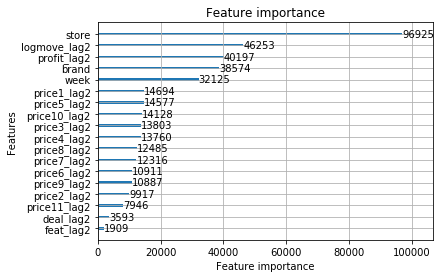

In [10]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=20)
plt.show()

In [11]:
metric_all

[78.2321096879806,
 76.06054868990037,
 100.13694699100049,
 84.50803699032221,
 147.68133658648387,
 145.3756747180339,
 107.86563394849149,
 68.94518028854979,
 117.93093552051434,
 118.31807915081072,
 94.7643136827172,
 85.38085750184624]

In [12]:
np.mean(metric_all)

102.0999711463876